In [8]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

# load Green Infrastructure Data


In [9]:
pluto_ogrio = gpd.read_file("../Data/DEP Green Infrastructure/geo_export_3298f6ed-a61a-4d9f-a900-907faeaebf16.shp")

# basic exploration


In [10]:
pluto_ogrio.columns

Index(['assembly_d', 'asset_area', 'asset_id', 'asset_leng', 'asset_type',
       'asset_widt', 'asset_x_co', 'asset_y_co', 'bbl', 'borough',
       'city_counc', 'community_', 'construc_1', 'constructi', 'dep_cont_1',
       'dep_contra', 'gi_feature', 'gi_id', 'nyc_waters', 'outfall',
       'program_ar', 'project_na', 'row_onsite', 'secondary_', 'sewer_type',
       'status', 'status_gro', 'tree_commo', 'tree_latin', 'geometry'],
      dtype='object')

There is a list of data describing Green Infrastructure Initiative by Borough.  The information lists permeable water drainage system that prevents potential flooding in NYC.   

In [6]:
pluto_ogrio.dtypes

assembly_d     float64
asset_area     float64
asset_id       float64
asset_leng     float64
asset_type      object
asset_widt     float64
asset_x_co     float64
asset_y_co     float64
bbl            float64
borough         object
city_counc     float64
community_     float64
construc_1      object
constructi      object
dep_cont_1      object
dep_contra      object
gi_feature      object
gi_id           object
nyc_waters      object
outfall         object
program_ar      object
project_na      object
row_onsite      object
secondary_     float64
sewer_type      object
status          object
status_gro      object
tree_commo      object
tree_latin      object
geometry      geometry
dtype: object

This is a list of different types of data from this data set.

## categorical column


In [7]:
pluto_ogrio.nyc_waters.value_counts()

nyc_waters
Jamaica Bay and Tributaries    6596
Flushing Creek                 2179
East River / Open Waters       2004
Newtown Creek                  1579
Flushing Bay                    791
Bronx River                     441
Westchester Creek               224
Hutchinson River                194
Gowanus Canal                   124
Coney Island Creek               49
Alley Creek                       9
Name: count, dtype: int64

This list describes all the water ways and tributaries to which the drained excess water would leave the city. It also lists the number of drainages that each NYC water source would receive.

🧐 What do those numbers mean? Let's look at the [data dictionary](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/meta_mappluto.pdf)


In [8]:
pluto_ogrio.groupby(["borough","nyc_waters"]).asset_area.sum()

borough        nyc_waters                 
Bronx          Bronx River                     266832.95
               East River / Open Waters        380241.39
               Hutchinson River                169015.39
               Westchester Creek                45312.17
Brooklyn       Coney Island Creek               29461.00
               East River / Open Waters        484196.50
               Gowanus Canal                   325329.07
               Jamaica Bay and Tributaries     853994.35
               Newtown Creek                   199531.98
Manhattan      East River / Open Waters       1190239.03
Queens         Alley Creek                      16572.00
               Bronx River                        270.00
               East River / Open Waters        367460.22
               Flushing Bay                    148781.02
               Flushing Creek                  470109.87
               Jamaica Bay and Tributaries     541460.00
               Newtown Creek                 

This is a list separated by boroughs.

<Axes: xlabel='borough'>

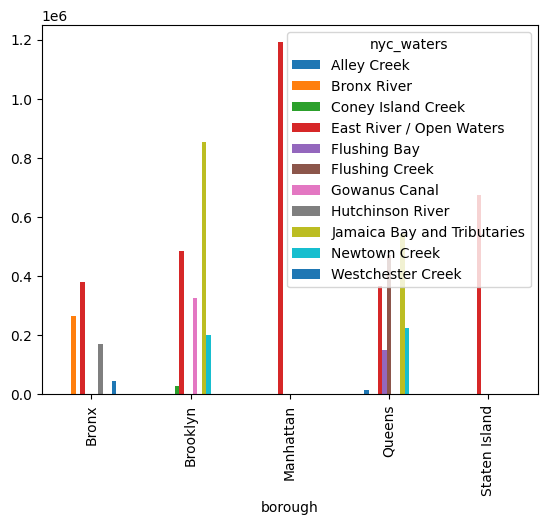

In [9]:
pluto_ogrio.groupby(["borough","nyc_waters"]).asset_area.sum().unstack().plot.bar()

This graph shows the amount of excess water that travel from each borough into individual water source.

<Axes: xlabel='nyc_waters'>

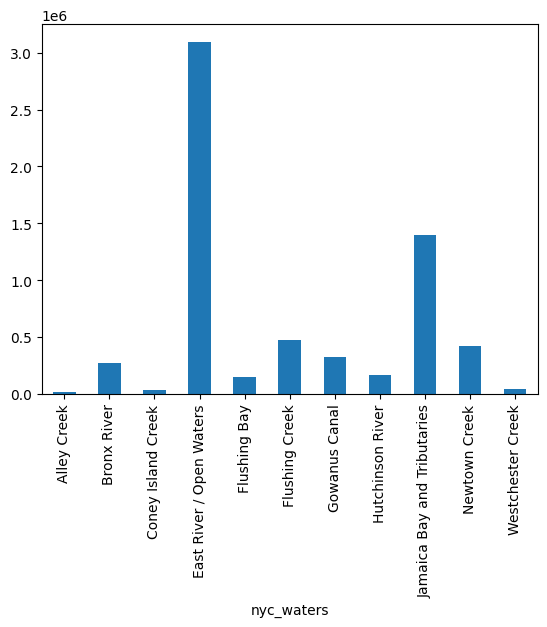

In [10]:
pluto_ogrio.groupby(["nyc_waters"]).asset_area.sum().plot.bar()

The bar graph displays the amount of excess water draining to each tributaries.

Text(0.5, 1.0, 'Total asset area by water drainage')

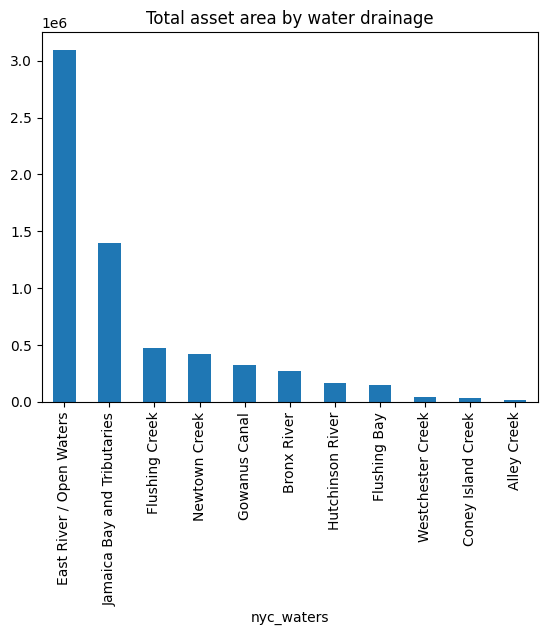

In [11]:
pluto_ogrio.groupby("nyc_waters").asset_area.sum().sort_values(ascending=False).plot.bar()
plt.title("Total asset area by water drainage")

This bar graph describes in the order of greater to smaller amount of excess water drainage.

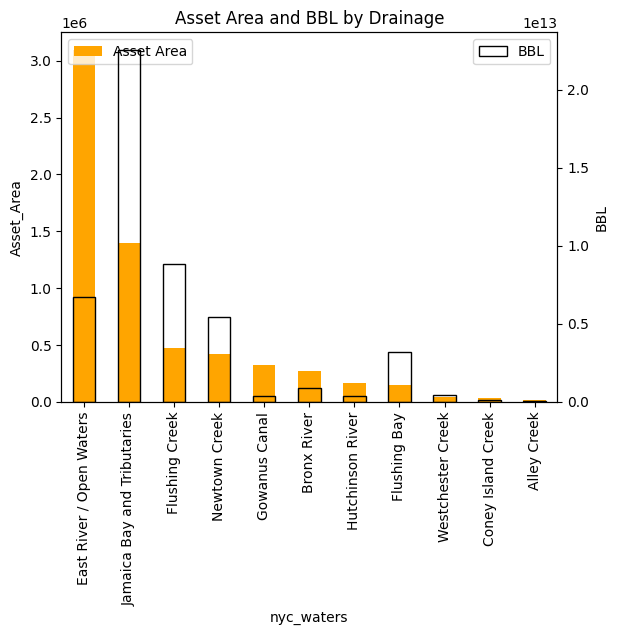

In [12]:
# plot both lot and building area on the same plot with a secondary y-axis
fig, ax = plt.subplots()
by_lot_area = pluto_ogrio.groupby("nyc_waters").asset_area.sum().sort_values(ascending=False)

by_lot_area.plot.bar(ax=ax, color="orange")

# get order to apply below
order = {v: i for i, v in enumerate(by_lot_area.index)}

ax.set_ylabel("Asset_Area")
ax.set_xlabel("nyc_waters")

ax2 = ax.twinx()
pluto_ogrio.groupby("nyc_waters").bbl.sum().reindex(by_lot_area.index).plot.bar(
    ax=ax2, edgecolor="black", color="none"
)
ax2.set_ylabel("BBL")

plt.title("Asset Area and BBL by Drainage")

# add legends
ax.legend(["Asset Area"], loc="upper left")
ax2.legend(["BBL"], loc="upper right")

This graph contrasts the excess water amount difference between asset area vs. BBL.

## numeric column


In [14]:
pluto_ogrio["asset_area"].describe()

count     14190.000000
mean        450.217921
std        5855.217598
min           1.000000
25%          50.000000
50%          65.000000
75%          93.500000
max      435000.000000
Name: asset_area, dtype: float64

<Axes: ylabel='Frequency'>

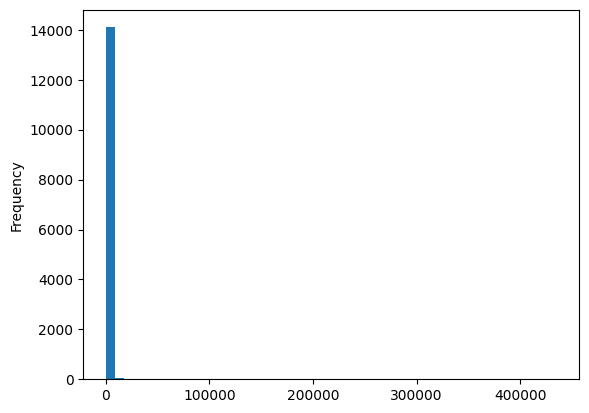

In [15]:
pluto_ogrio["asset_area"].plot.hist(bins=50)

The Frequency described here is not useful as the data seems to refer to two specific data and one is greatly bigger than the other. They must not be relevant or the comparison is not of the same caliber.

<Axes: title={'center': 'asset_area'}, xlabel='borough'>

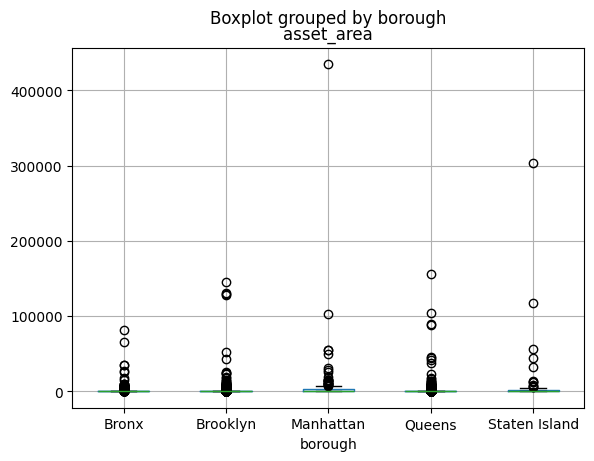

In [16]:
pluto_ogrio.boxplot(column="asset_area", by="borough")

This Boxplot describes mean asset area of excess water drained in each borough and it also shows outliers from each borough.


# cluster by NYC Water Sources


In [22]:
# get clusters using kmeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(pluto_ogrio[["bbl", "asset_area"]])

pluto_ogrio["NYC_Water_Cluster"] = kmeans.predict(pluto_ogrio[["bbl", "asset_area"]])

In [23]:
pluto_ogrio.groupby("NYC_Water_Cluster").asset_area.describe().sort_values("max")

,count,mean,std,min,25%,50%,75%,max
NYC_Water_Cluster,,,,,,,,
2,1003.0,736.331256,2981.781163,1.0,58.500,80.42,244.155,65063.63
1,5802.0,342.696493,3906.288786,1.0,52.000,70.00,100.000,145471.00
0,7094.0,252.325960,2989.812811,1.0,50.000,60.00,80.000,156052.00
4,64.0,10555.157969,40972.968694,120.0,589.925,1079.80,2390.750,303481.00
3,227.0,5269.588238,30309.672771,40.0,142.070,582.48,2159.850,435000.00


This table describes Clusters of NYC water sources.

<Axes: xlabel='asset_area', ylabel='bbl'>

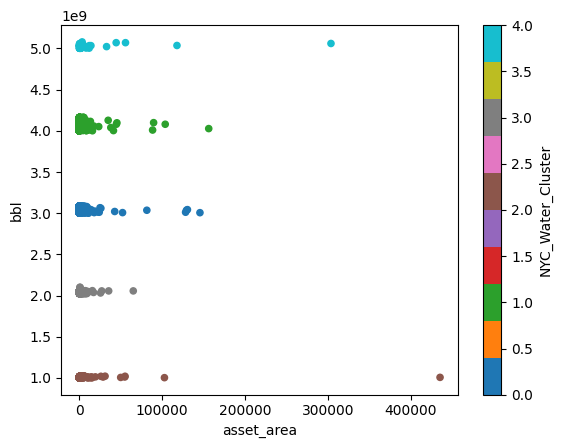

In [19]:
pluto_ogrio.plot.scatter(x="asset_area", y="bbl", c="NYC_Water_Cluster", cmap="tab10")

<Axes: ylabel='Frequency'>

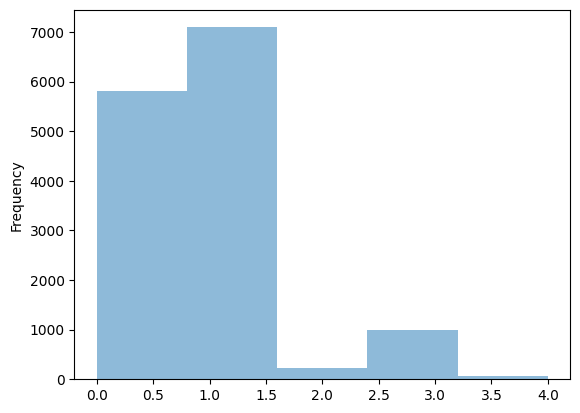

In [20]:
pluto_ogrio["NYC_Water_Cluster"].plot.hist(bins=5, alpha=0.5)

## static map


Text(0.5, 1.0, 'NYC MapWater')

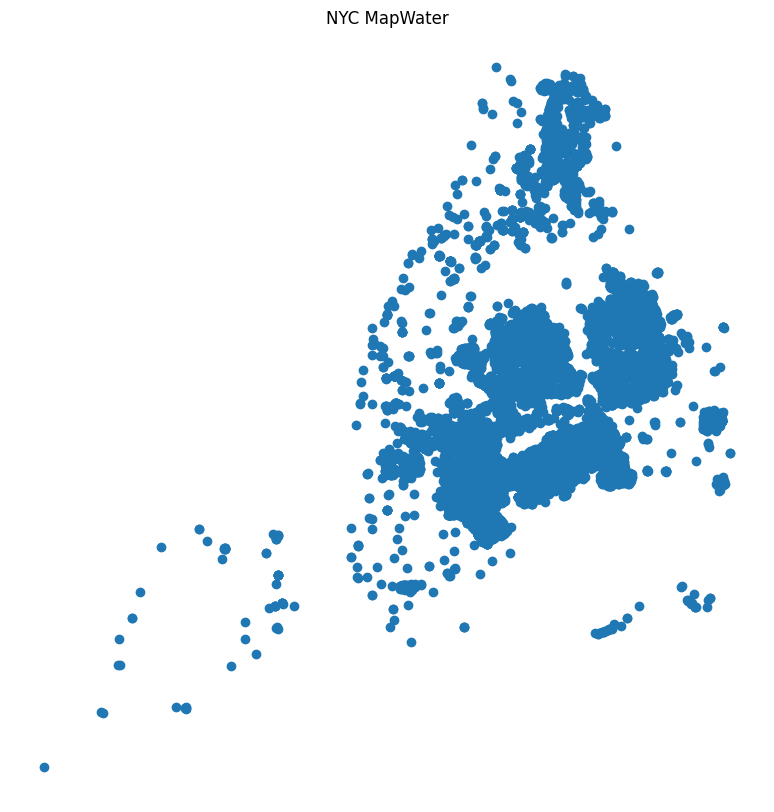

In [13]:
pluto_ogrio.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC MapWater")

In [17]:
cmap = {
    "East River / Open Waters": "#ff0000",
    "Jamaica Bay and Tributaries": "#00ff00",
    "Flushing Creek": "#0000ff",
    "Newtown Creek": "#ff00ff",
    "Gowanus Canal": "#00ffff",
    "Bronx River": "#ffff00",
    "Hutchinson River": "#808080",
    "Flushing Bay": "#800000",
    "Westchester Creek": "#008000",
    "Coney Island Creek": "#000080",
    "Alley Creek": "#800080",
    "Unknown": "#000000",
}

In [15]:
pluto_ogrio.fillna({"nyc_waters": "Unknown"}, inplace=True)

In [18]:
pluto_ogrio["color"] = pluto_ogrio["nyc_waters"].map(cmap)

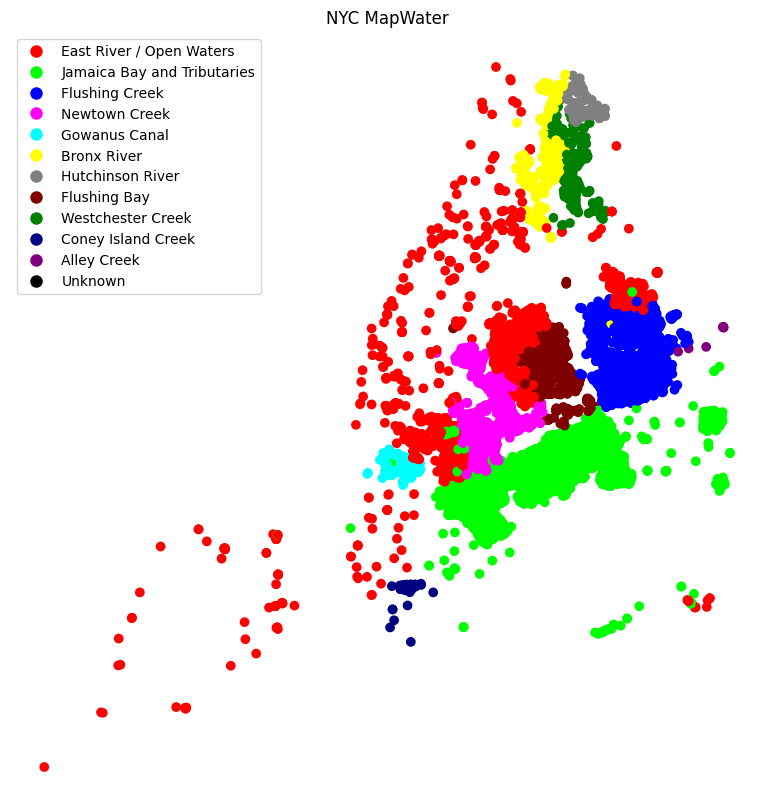

In [20]:
ax = pluto_ogrio.plot(
    color=pluto_ogrio["color"],
    figsize=(10, 10),
    legend=True,
).set_axis_off()
plt.title("NYC MapWater")


# populate legend items based on dict from above
legend_colors = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")